In [1]:
import torch
import torch.nn.functional as F
import pandas
import torchaudio
import torchaudio.transforms as T
import os
from datasets import load_dataset,Audio
import numpy as np
from ..src.utils.datasets import TimitDataset
from torch.utils.data import Dataset, DataLoader
#from sklearn.model_selection import train_test_split
torchaudio.set_audio_backend("soundfile")

In [2]:
from torchmetrics import Metric
from torch import Tensor
class ExpectedCost(Metric):
    """
    Wrapper on the expected cost as defined in https://github.com/luferrer/expected_cost
    """
    def __init__(self,task = "binary", costs=None, priors=None, sample_weight=None, adjusted=False,num_classes = 2):
        super().__init__()
        self.conf = ConfusionMatrix(task=task,num_classes=num_classes)
        if costs is None:
            
            costs = 1-torch.eye(num_classes)
            
            self.costs = costs
        else:
            self.costs = costs
        self.priors = priors
        self.sample_weight = sample_weight
        self.adjusted=adjusted
        self.num_classes = num_classes
        
            
        self.add_state("bincounts", default=torch.zeros(num_classes), dist_reduce_fx="sum")
        self.add_state("matrix", default=torch.zeros((num_classes,num_classes)), dist_reduce_fx="sum")
        
    def _input_format(self,preds,target):
        return preds,target
    def update(self, preds: Tensor, target: Tensor):
        preds, target = self._input_format(preds, target)
        
        assert preds.shape == target.shape
        self.matrix = self.conf(preds,target)
        
        self.bincounts = torch.bincount(target,minlength=self.num_classes)
        
    def compute(self):
        self.matrix = self.matrix/self.matrix.sum(axis=1, keepdims=True)
        priors = (self.bincounts/self.bincounts.sum()).unsqueeze(0).T
        if self.adjusted:
            # When adjusted is true, normalize the average cost
            # with the cost of a naive system that always makes
            # the min cost decision.
            norm_value = torch.min(torch.dot(priors.T, self.costs))
        else:
            norm_value = 1.0
                
        ave_cost = torch.sum(priors * self.costs * self.matrix)

        return ave_cost / norm_value

### Timit (phonemes)

In [6]:
tmp = TimitDataset(mode="train")
len(tmp)

Cleaning.......OK
Dataset preparation


177080

In [5]:
177080-150000

27080

In [7]:
dataset_train,dataset_valid = torch.utils.data.random_split(tmp, [150000, 27080])


In [3]:
dataset_test = TimitDataset(mode="test")

Cleaning.......OK
Dataset preparation


### Dataset test

In [9]:
import IPython.display as ipd


print(f"Length of train set: {len(dataset_train)}")

print(f"Length of valid set: {len(dataset_valid)}")

print(f"Length of test set: {len(dataset_test)}")

Length of train set: 150000
Length of valid set: 27080
Length of test set: 64145


## Load NMF-based multilabel segmentation model

In [9]:
import yaml
from pyannote.audio import Model

w_nmf = torch.load("/lium/raid01_b/tmario/phD/JSALT2023/src/1.explainability/nmf/src/nmf/w_nmf_256_1024_nn_augment.pt")
with open("/lium/raid01_b/tmario/phD/JSALT2023/src/1.explainability/nmf/config_wavlm.yaml","rb") as fh:
    cfg = yaml.safe_load(fh)
model = Model.from_pretrained("/lium/raid01_b/tmario/phD/JSALT2023/src/1.explainability/nmf/3MASNMF/augment/X.Segmentation.Full_WP2-augment-10.0-1.0-0.1-augTrue/models/23_11_14.ckpt",
                              w_nmf=w_nmf,
                              wavlm_cfg=cfg["model"]["wavlm"],
                              spec_kw={"win_length":1024, "hop_length":320,"n_fft":1024})
model.freeze()

Type of NMF matrix: <class 'torch.Tensor'> torch.Size([513, 256])


Using cache found in /lium/home/mlebour/.cache/torch/hub/s3prl_s3prl_main


In [ ]:
# Sparser MNF

In [4]:
import yaml
from pyannote.audio import Model

w_nmf = torch.load("/lium/raid01_b/tmario/phD/JSALT2023/src/1.explainability/nmf/dict/W_win_1024_nfft_1024_256_beta_2_mu_1_AragonRadio_sp_200_mus_500_no_500_max_seg_4.pt")
with open("/lium/raid01_b/tmario/phD/JSALT2023/src/1.explainability/nmf/config_wavlm.yaml","rb") as fh:
    cfg = yaml.safe_load(fh)
model = Model.from_pretrained("/lium/raid01_b/tmario/phD/JSALT2023/src/1.explainability/nmf/3MASNMF/make_it_sparser_256/X.Segmentation.Full_WP2-make_it_sparser_256-10.0-5.0-0.1-augTrue/models/23_12_12.ckpt",
                              w_nmf=w_nmf,
                              wavlm_cfg=cfg["model"]["wavlm"],
                              spec_kw={"win_length":1024, "hop_length":320,"n_fft":1024})
model.freeze()

Type of NMF matrix: <class 'torch.Tensor'> torch.Size([513, 256])


Using cache found in /lium/home/mlebour/.cache/torch/hub/s3prl_s3prl_main


### Classifier instance

In [10]:
#nmf_order=256
#n_classes = len(dataset_train.get_classes())
#classif_probe=torch.nn.Linear(nmf_order,n_classes,bias=True)

In [6]:
class LinProbe(torch.nn.Module):
    
    def __init__(self,input_size=64,output_size=10):
        super().__init__()
        self.probe = torch.nn.Sequential(torch.nn.Linear(2*input_size,output_size))
    
    def forward(self,x):
        x_mean = x.mean(dim=1)
        x_std = x.std(dim=1)
        
        y = self.probe(torch.cat([x_mean,x_std],dim=-1))
        
        return y

In [5]:
class LinProbe(torch.nn.Module):
    
    def __init__(self,input_size=256,output_size=10,agreg = "mean_std"):
        super().__init__()
        self.agreg = agreg
        weight = 1 if agreg in ["mean","std"] else 2
        
        self.probe = torch.nn.Sequential(torch.nn.Linear(weight*input_size,output_size))
    
    def forward(self,x):
        x_mean = None
        x_std = None
        if "mean" in self.agreg:
            x_mean = x.mean(dim=1)
        if "std" in self.agreg:
            x_std = x.std(dim=1)
        if x_mean is not None and x_std is not None:
            input_x = torch.cat([x_mean,x_std],dim=-1)
        elif x_mean is not None:
            input_x = x_mean
        elif x_std is not None:
            input_x = x_std
        
        y = self.probe(input_x)
        
        return y

In [5]:
from tqdm import tqdm

def train_epoch(seg_model,classif_probe,dataloader,loss_fun,optimizer,device="cpu"):
    avg_loss=0
    last_avg_loss=0
    for batch_idx, (data,label) in enumerate(tqdm(dataloader)):    
        optimizer.zero_grad()
        
        with torch.no_grad():
            feat = seg_model.wavlm(data.to(device))
            emb = seg_model.emb_transform(feat)
        
        logits = classif_probe(emb.permute(0,2,1))
        
        loss = loss_fun(logits,label.to(device))
        loss.backward()
        optimizer.step()
        
        avg_loss += loss
        
        if batch_idx%10 == 0:
            avg_loss/=10
            last_avg_loss=avg_loss
            print(f"Train loss: {avg_loss}")
            avg_loss=0
        
    return classif_probe, last_avg_loss

def valid_epoch(seg_model,classif_probe,dataloader,loss_fun,device="cpu"):
    valid_loss=0.0
    for batch_idx, (data, label) in enumerate(tqdm(dataloader,desc="Validation")):        
        
        with torch.no_grad():
            feat = seg_model.wavlm(data.to(device))
            emb = seg_model.emb_transform(feat)
        
        logits = classif_probe(emb.permute(0,2,1))   
        
        valid_loss += loss_fun(logits,label.to(device))
        
    return valid_loss/(batch_idx+1)

In [ ]:
n_epoch = 50

classif_probe = LinProbe(input_size=256,output_size=len(tmp.list_phone))

train_loader= DataLoader(dataset_train, batch_size=256, shuffle=True,num_workers=10)
valid_loader = DataLoader(dataset_valid, batch_size=256, shuffle=False,num_workers=10)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classif_probe.parameters(),lr=0.01)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)
classif_probe.to(device)

best_valid = 1e8

train_loss = []
valid_loss = []
for epoch in range(1,n_epoch+1):
    print(f"Epoch {epoch}")
    classif_probe, train_loss_t = train_epoch(seg_model=model,classif_probe=classif_probe,dataloader=train_loader,loss_fun=loss_fn,optimizer=optimizer,device=device)
    valid_loss_t = valid_epoch(seg_model=model,classif_probe=classif_probe,dataloader=valid_loader,loss_fun=loss_fn,device=device)
    print(f"Validation loss = {valid_loss}")
    
    train_loss.append(train_loss_t)
    valid_loss.append(valid_loss_t)
    
    if valid_loss_t < best_valid:
        torch.save(classif_probe.state_dict(), "phone_probe.pt")
        best_valid = valid_loss_t
    

In [ ]:
epochs = range(1,n_epoch+1)
epochs = range(1,20)
train_loss = [i.detach().cpu() for i in train_loss]
valid_loss = [i.detach().cpu() for i in valid_loss]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,5),layout="constrained")
ax.plot(epochs,train_loss,linewidth=2,color="b",label='Train')
ax.plot(epochs,valid_loss,linewidth=2,color="r",label='Valid')
ax.grid()

ax.legend()

ax.set_xlabel("Epoch index")
ax.set_ylabel("Cross Entropy")
ax.set_title("Training curves for phonemes")

plt.show()

fig.savefig("train_gender_detection.png",dpi=300)

In [6]:
import matplotlib.pyplot as plt

In [7]:
test_loader= DataLoader(dataset_test, batch_size=128, shuffle=False,num_workers=10)

In [9]:
ckpt = torch.load("probes/sparse_phone_probe_256_norepeat_mean_39.pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(len(dataset_test.list_phone))
classif_probe = LinProbe(input_size=256,output_size=len(dataset_test.list_phone),agreg="mean")
classif_probe.load_state_dict(ckpt)
classif_probe.to(device)
model.to(device)

39


MASNMF(
  (spec_feat): SpecFeat(
    (spec): Spectrogram()
  )
  (wavlm): WavLM_Feats(
    (feature_extract): UpstreamExpert(
      (model): WavLM(
        (feature_extractor): ConvFeatureExtractionModel(
          (conv_layers): ModuleList(
            (0): Sequential(
              (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
              (1): Dropout(p=0.0, inplace=False)
              (2): Sequential(
                (0): TransposeLast()
                (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
                (2): TransposeLast()
              )
              (3): GELU()
            )
            (1): Sequential(
              (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
              (1): Dropout(p=0.0, inplace=False)
              (2): Sequential(
                (0): TransposeLast()
                (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
                (2): TransposeLast()
              )
     

In [10]:
from tqdm import tqdm
pred = []
lab = []
for batch_idx, (data,label) in enumerate(tqdm(test_loader)):    

    with torch.no_grad():
        feat = model.wavlm(data.to(device))
        emb = model.emb_transform(feat)
        lab.extend(label.detach().cpu().numpy())
        
        logits = classif_probe(emb.permute(0,2,1))
        #print(logits.shape)
        pred.extend(logits.argmax(dim=-1).detach().cpu().numpy())

        

100%|██████████| 502/502 [02:16<00:00,  3.69it/s]


In [24]:
from torchmetrics import F1Score,Accuracy,ConfusionMatrix,Recall
f1 = F1Score(task="multiclass",num_classes=len(dataset_test.list_phone),average="macro")
recall = Recall(task="multiclass",num_classes=len(dataset_test.list_phone),average="macro")
acc = Accuracy(task='multiclass',num_classes=len(dataset_test.list_phone))
conf = ConfusionMatrix(task='multiclass',num_classes=len(dataset_test.list_phone),normalize="true")
ecp = ExpectedCost(task="multiclass",num_classes=len(dataset_test.list_phone))

In [13]:
import numpy as np
tpred = torch.from_numpy(np.array(pred))
tlabel = torch.from_numpy(np.array(lab))

In [18]:
len(tmp.list_phone)

61

In [20]:

from expected_cost import ec
#print("0 Male, 1 Female")

print("Acc =",acc(tpred,tlabel))
print("F1score =",f1(tpred,tlabel))
print("UAR =",recall(tpred,tlabel))
#print("F1score Male =",f1((tpred*-1)+1,(tlabel*-1)+1))
#print("Confusion = ",conf(tpred,tlabel))
print("\nCUSTOM EC")
print("Expected cost",ecp(tpred,tlabel))
print("Acc from EC",1-ecp(tpred,tlabel))


Acc = tensor(0.5064)
F1score = tensor(0.2927)
UAR = tensor(0.3021)

CUSTOM EC
Expected cost tensor(nan)
Acc from EC tensor(nan)


<Axes: >

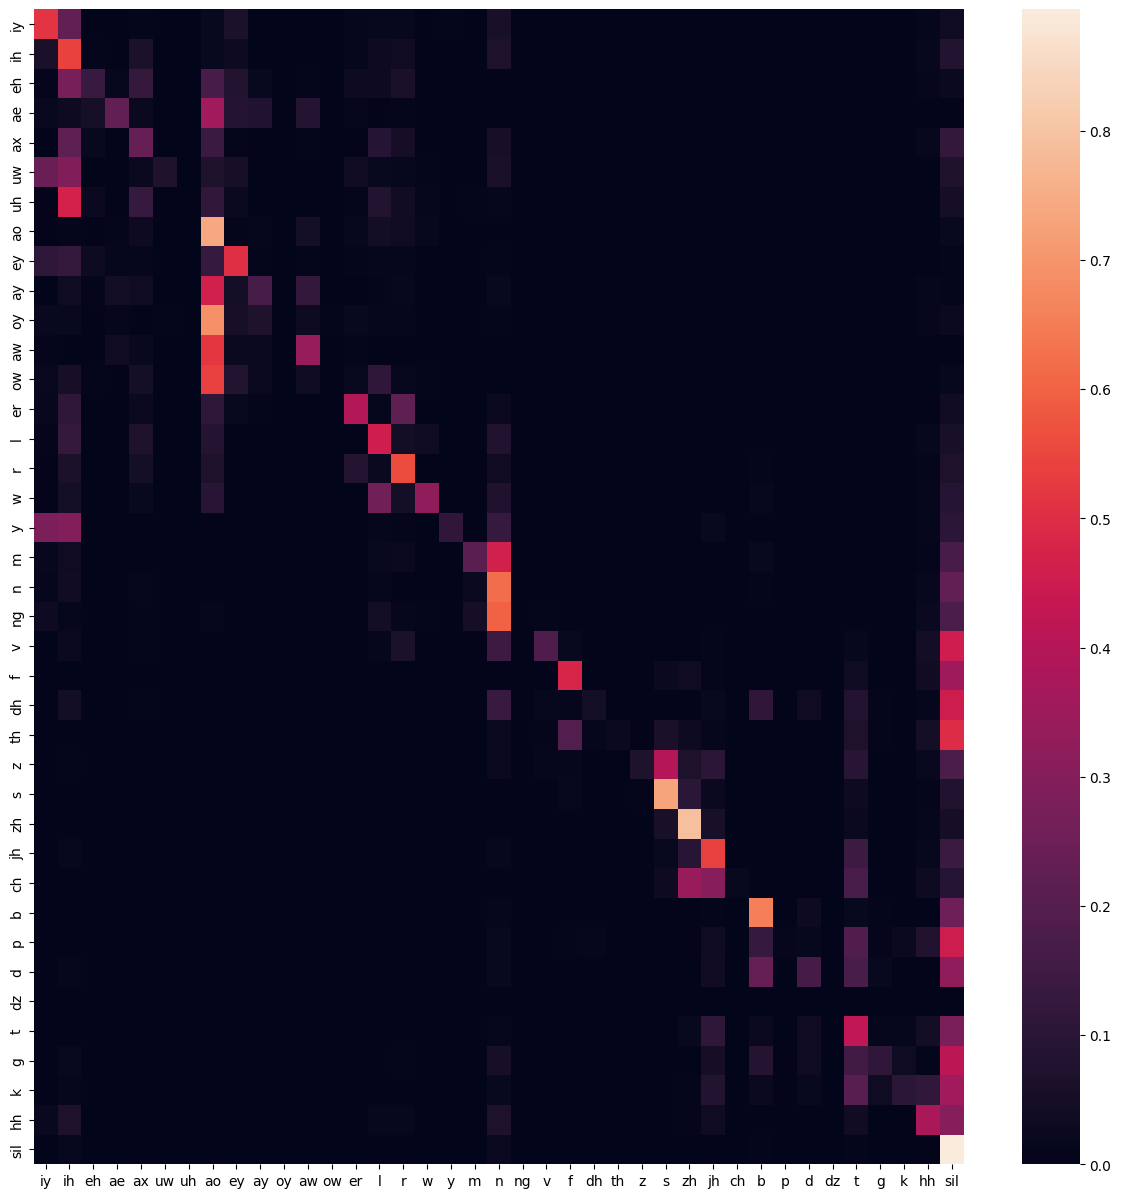

In [25]:
import seaborn as sn
plt.figure(figsize=(15,15))

sn.heatmap(conf(tpred,tlabel),xticklabels=dataset_test.list_phone,yticklabels=dataset_test.list_phone)

torch.Size([512])
torch.Size([1, 512])
tensor([-1.0000])


<Axes: >

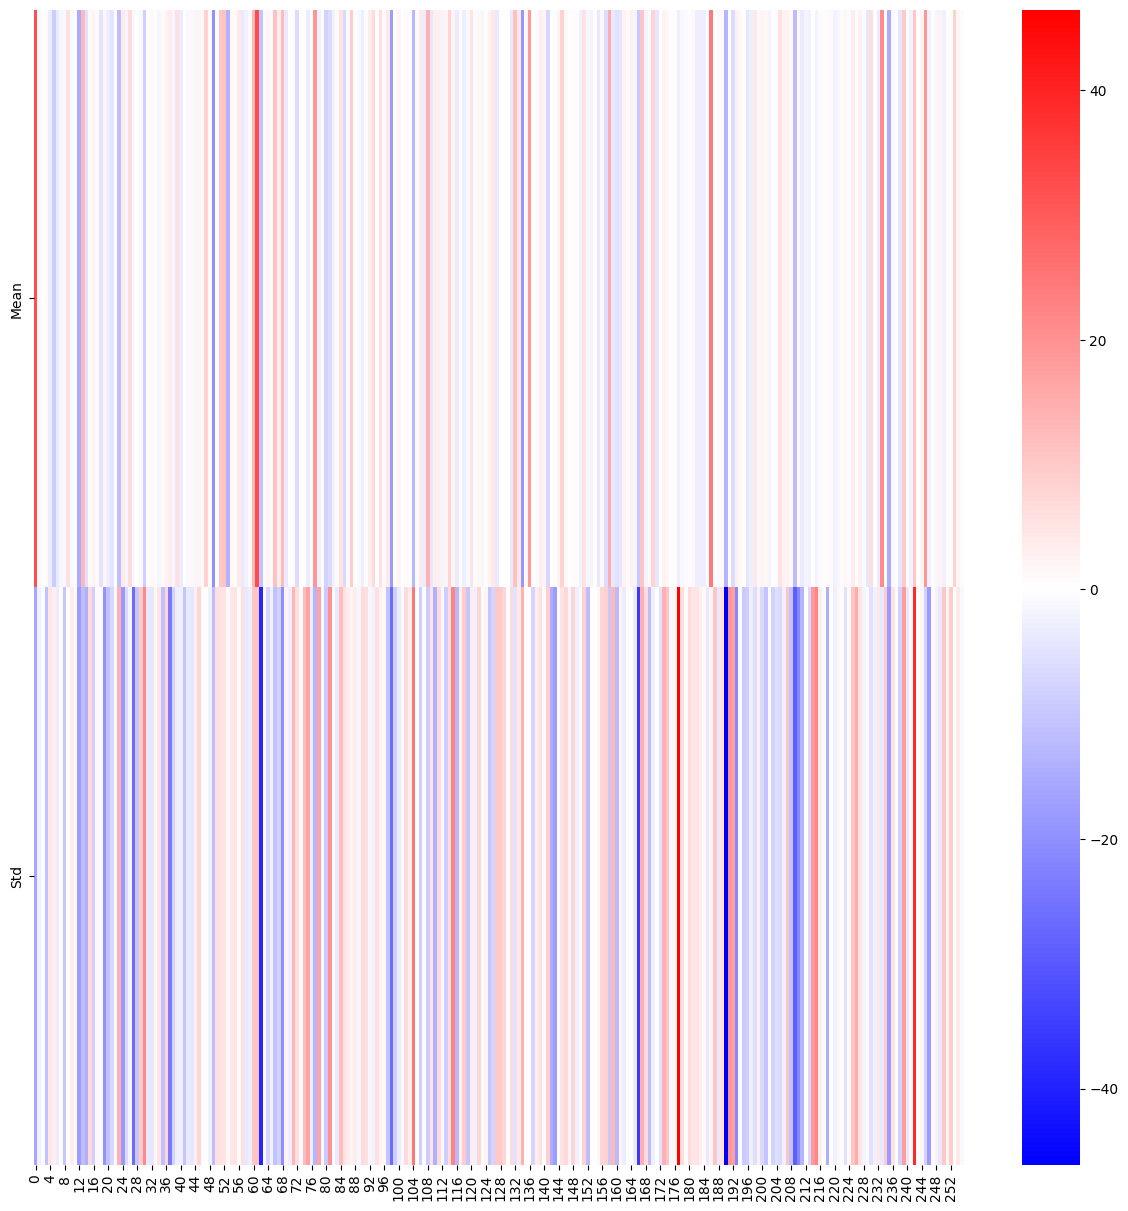

In [40]:
plt.figure(figsize=(15,15))
print(ckpt['probe.0.weight'].cpu()[0].shape)
male,female = ckpt['probe.0.weight'].cpu()[0].unsqueeze(0),ckpt['probe.0.weight'].cpu()[1].unsqueeze(0)
print(female.shape)
print(torch.nn.functional.cosine_similarity(male,female))

sn.heatmap(female.reshape(2,256),cmap='bwr',yticklabels=['Mean','Std'])